#**03 심층 신경망으로 이미지 분류**
이미지 분류를 위해 더 깊은 층을 쌓아 깊이 있는 딥러닝 모델 생성

##**3-1 케라스 내장 데이터셋 로드**


```
- boston_housing : 보스톤 주택 가격 데이터셋(회귀)
- cifar10 : CIFAR10 이미지 분류 데이터셋(분류)
- cifar100 : CIFAR100 이미지 분류 데이터셋(분류)
- mnist : mnist 손글씨 데이터셋(분류)
- fashion_mnist : 의류 데이터셋(분류)
- imdb : IMDb 영화 데이터셋(분류)
- reuters : Reuters 뉴스 토픽(분류)
```



In [1]:
import tensorflow as tf

#케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

mnist 변수에 `load_data()` 메소드를 적용하면 google의 storage로부터 넘파이 배열(numpy ndarray)로 구성된 데이터셋을 다운로드 받음
- 훈련 데이터셋과 검증 데이터셋을 반환하므로 투플 형태로 정의한다.
- `x_train, y_train` : 훈련셋의 입력데이터와 출력데이터
- `x_test, y_test` : 검증셋의 입력과 출력데이터


In [2]:
#load_data()로 데이터셋 로드
(x_train, y_train),(x_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


- 훈련 셋에는 60000개의 데이터, 검증 셋에는 10000개의 데이터가 저장되어 있다.
- x_train, x_test : 손글씨 이미지 데이터
- 배열의 shape : (데이터셋 크기, 가로, 세로)
- 입력 데이터의 출력은 1차원 벡터 형태

In [3]:
#로드된 데이터셋 확인
print('train set:',x_train.shape, y_train.shape)
print('test  set:',x_test.shape, y_test.shape)

train set: (60000, 28, 28) (60000,)
test  set: (10000, 28, 28) (10000,)


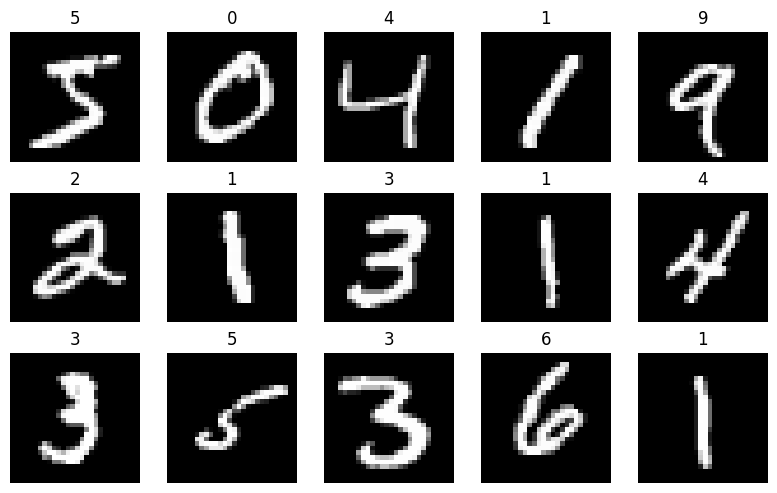

In [4]:
#데이터 시각화
import matplotlib.pyplot as plt

#canvas 생성
fig,axes = plt.subplots(3,5)
fig.set_size_inches(8,5)

for i in range(15):
  ax = axes[i//5, i%5]
  #imshow로 이미지 시각화
  ax.imshow(x_train[i], cmap='gray')
  ax.axis('off')
  ax.set_title(str(y_train[i]))

plt.tight_layout()
plt.show()

- mnist 데이터셋은 딥러닝 세계의 'Hello, World' 데이터셋으로 불림
- 1990년대 초반 얀 르쿤은 사람의 손글씨를 인식하는 프로그램을 개발했는데, 그 당시 사용했던 손글씨 데이터셋이 지금까지 활용되고 있음
- mnist 데이터셋은 사람의 필기체로 쓰인 0~9까지의 숫자들로 이루어진 데이터셋

##**3-2 데이터 전처리**
이미지 데이터에 대해 정규화를 통해 데이터의 범위를 조절한다.
- x_train은 넘파이 배열
- 배열의 각 원소는 이미지를 구성하는 하나의 픽셀 값과 일대일 매칭됨

In [5]:
#x_train 배열의 데이터 확인
x_train[0, 10:15, 10:15]

array([[  1, 154, 253,  90,   0],
       [  0, 139, 253, 190,   2],
       [  0,  11, 190, 253,  70],
       [  0,   0,  35, 241, 225],
       [  0,   0,   0,  81, 240]], dtype=uint8)

In [6]:
#픽셀 값의 최소/최대값 확인
print(f'정규화 전] 최소값: {x_train.min()}, 최대값: {x_train.max()}')

#데이터 정규화
x_train = x_train / x_train.max()

#정규화 후 최소/최대값 확인
print(f'정규화 후] 최소값: {x_train.min()}, 최대값: {x_train.max()}')

정규화 전] 최소값: 0, 최대값: 255
정규화 후] 최소값: 0.0, 최대값: 1.0


In [7]:
#test 셋에도 정규화 동일 적용
x_test = x_test / x_test.max()

In [8]:
#변환 후 x_train 배열의 데이터 확인
x_train[0,10:15,10:15]

array([[0.00392157, 0.60392157, 0.99215686, 0.35294118, 0.        ],
       [0.        , 0.54509804, 0.99215686, 0.74509804, 0.00784314],
       [0.        , 0.04313725, 0.74509804, 0.99215686, 0.2745098 ],
       [0.        , 0.        , 0.1372549 , 0.94509804, 0.88235294],
       [0.        , 0.        , 0.        , 0.31764706, 0.94117647]])

> **정규화**

- 데이터의 전체 범위를 0~1 사이의 값을 가지도록 한다.
- 입력 데이터가 정규화되어 모델이 학습하는 경우 경사하강법 알고리즘에 의한 수렴 속도가 비정규화된 입력 데이터를 가질 때보다 더 빨리 수렴하기 때문
- 국소 최적(local optimum)에 빠지는 현상을 방지

##**3-3 Flatten 레이어**
- 정규화를 하면 개별 데이터 값의 범위는 축소되지만 원본 배열의 형태는 그대로 유지된다.
- 샘플 이미지의 형태는 (28,28)로 이루어져 있고 2차원 입력으로 볼 수 있다.
- Dense 레이어에는 입력값으로 반드시 1차원 배열이 들어가야 하므로 1차원 전처리가 필요하다.


In [9]:
print(f'변경 전 shape: {x_train.shape}')
print(f'1D으로 변경 후: {x_train.reshape(60000,-1).shape}')

변경 전 shape: (60000, 28, 28)
1D으로 변경 후: (60000, 784)


In [10]:
print(f'변경 전 shape:{x_train.shape}')

#Flatten 적용 후 shape 확인
print(f'Flatten 적용 후:{tf.keras.layers.Flatten()(x_train).shape}')

변경 전 shape:(60000, 28, 28)
Flatten 적용 후:(60000, 784)


##**3-4 활성화 함수**
**활성화 함수(Activation Function)** : 입력을 비선형 출력으로 변환해주는 함수
- 선형관계를 나타내는 함수에 비선형성을 추가하는 방법으로 표현되기도 함
- 비선형성을 추가하지 않고 선형 함수로만 층을 구성한다면 층이 깊더라도 선형함수로 표현됨
- 시그모이드(Sigmoid), 하이퍼볼릭 탄젠트(Hyperbolic Tangent), ReLU(Refined Unit), Leaky ReLU 등

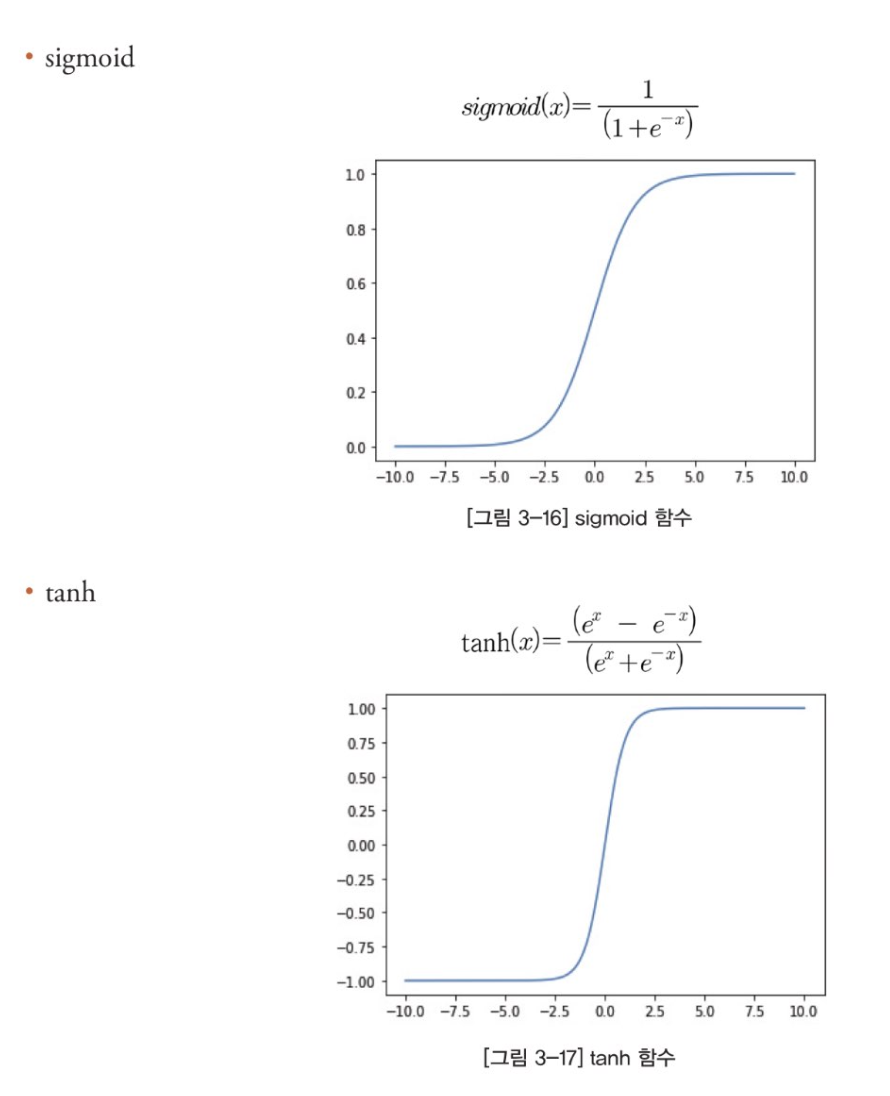

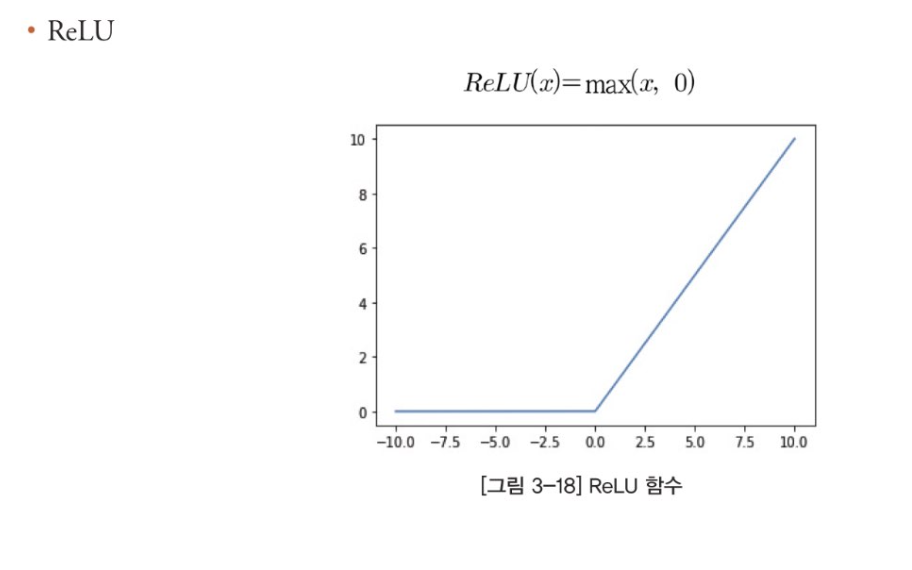

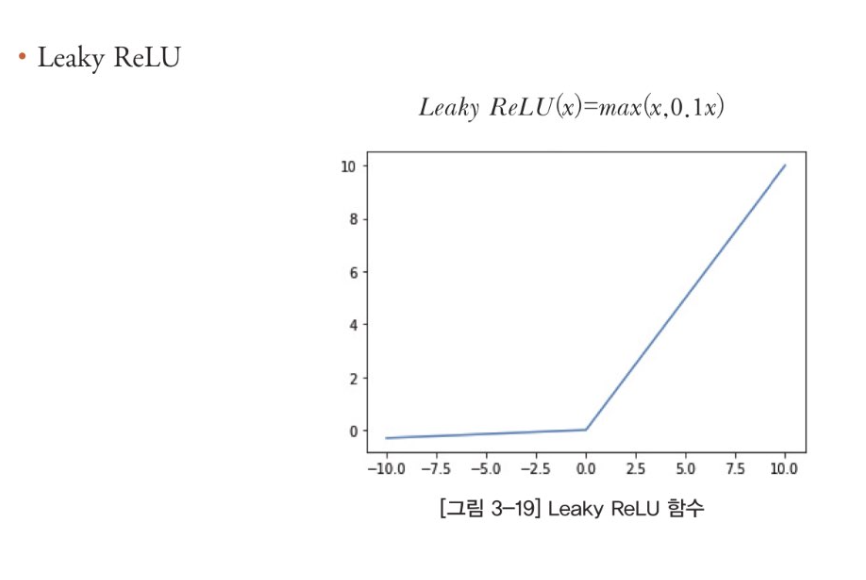

In [11]:
#Dense 레이어에 relu 활성화 함수를 적용한 경우
tf.keras.layers.Dense(128, activation='relu')

- 별도의 층처럼 구성하는 경우
  - Dense 레이어 다음에 배치 정규화(Batch Normalization)를 적용한 후 활성화 함수를 적용하고자 할 때 많이 사용됨
  - 커스터마이징

In [12]:
#Dense 레이어와 relu 활성화 함수 레이어를 별도 적용한 경우
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu')
])

##**3-5 입력과 출력**
- 첫 번째 레이어에 입력 데이터의 형태를 나타내는 input_shape 매개변수를 지정
  - input_shape=(28,28)
- 마지막 레이어는 출력층, 출력층의 노드 개수는 반드시 분류해야 할 클래스의 수와 동일해야 함
  - mnist는 0~9까지 총 10개의 클래스로 이루어져있으므로 마지막 출력층의 노드 개수는 10개

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    #노드 = 10개(클래스 개수와 동일)
    tf.keras.layers.Dense(10, activation = 'softmax'),
])

> - Dense 레이어를 구성하는 노드의 개수는 256-64-32-10으로 조금씩 개수가 줄어드는 형태
- Flatten 층으로 이미지를 펼치면 784개의 픽셀 값이 각각 입력 변수가 된다. 변수에 대한 입력값을 노드 개수를 줄여가면서 최종 출력 클래스 개수인 10개까지 정보를 축약
- 모델의 깊이와 너비(레이어의 개수와 노드의 개수)에 대한 정답은 없다. 레이어 개수와 노드 개수는 중요한 하이퍼파라미터

출력층의 노드 개수가 2개 이상인 경우에는 **softmax** 활성화함수를 적용
- 다중 분류 문제 = softmax

이진 분류 모델의 출력층 노드 개수를 1개로 설정한 경우 **sigmoid** 활성화 함수를 적용
- 이진 분류 모델이더라도 출력 레이어의 클래스를 원핫 인코딩으로 변환하여 노드 개수가 2개인 경우 softmax 사용

In [14]:
#출력층 노드 = 1인 경우, sigmoid
tf.keras.layers.Dense(1, activation='sigmoid')

#출력층 노드 = 2개 이상인 경우, softmax
tf.keras.layers.Dense(10, activation='softmax')

##**3-6 손실함수**
분류 모델의 손실함수는 모델의 출력층에 따라 올바른 손실함수를 설정해야만 모델이 정상적으로 훈련할 수 있다.

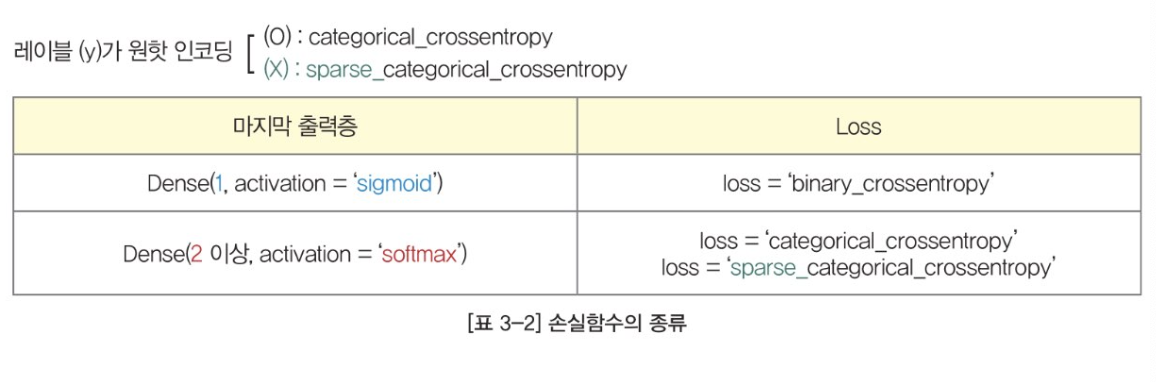

- 이진 분류기(binary classifier)
  - activation = 'sigmoid'
  - 손실함수 = 'binary_crossentropy'

In [15]:
#이진 분류(출력 노드 개수=1, sigmoid인 경우)
model.compile(loss='binary_crossentropy')

- 출력층의 노드가 2개 이상인 경우
  - activation = `'softmax'`
  - 손실함수 = `'categorical_crossentropy' or 'sparse_categorical_crossentropy'`
    - 출력 데이터가 원핫 벡터(one-hot vector) : `'categorical_crossentropy'`
    - 원핫 벡터가 아닌 경우 : `'sparse_categorical_crossentropy'`


In [16]:
#y가 원핫 벡터인 경우
#[0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,]
model.compile(loss='categorical_crossentropy')
#y가 원핫 벡터가 아닌 경우
#[5]
model.compile(loss='sparse_categorical_crossentropy')

- mnist 데이터셋은 클래스의 개수가 10개이므로 마지막 출력층에 해당하는 Dense 레이어의 노드 개수를 10으로 지정
- 출력 데이터가 원핫 벡터가 아니고, 0~9까지 레이블 값을 가지므로 `'sparse_categorical_crossentropy'`

##**3-7 옵티마이저**
옵티마이저(optimizer): 손실을 낮추기 위해서, 신경망의 가중치와 학습률과 같은 신경망의 속성을 변경하는 데 사용되는 최적화 기법
- 일반적으로 많이 사용되는 알고리즘은 Adam
- 케라스에서 지원하는 옵티마이저 : SGD, Adam, Adagrad, Nadam, RMSprop, Adadelta, Adamax, Ftrl

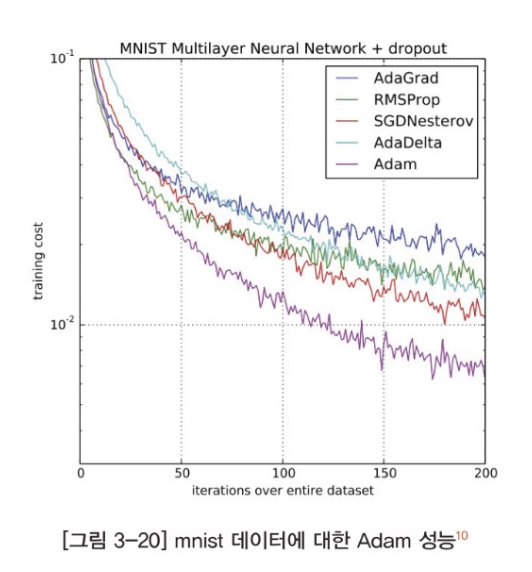

옵티마이저는 클래스 인스턴스로 지정하거나 문자열로 지정가능
- 문자열로 지정할 때 클래스 이름을 소문자로 표기
- 클래스 인스턴스로 지정할 때 하이퍼파라미터 직접 설정가능

In [17]:
#클래스 인스턴스로 지정
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam)

#문자열로 지정
model.compile(optimizer='adam')

##**3-8 평가지표**
모델 컴파일 단계에서 metrics 매개변수에 파이썬 리스트 형태로 하나 이상의 평가지표를 지정하여 여러 지표들을 동시에 참고할 수 있음

In [18]:
#클래스 인스턴스로 지정
acc=tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[acc])

In [19]:
#문자열로 지정
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

##**3-9 훈련**
- mnist 손글씨 데이터셋은 10000개로 구성된 별도의 검증 셋 존재
- 검증 셋을 (x_test, y_test)에 저장
- 훈련 시 검증 셋을 추가 지정하면 epoch마다 훈련 손실과 검증 손실, 각 셋에 대한 평가지표를 나란히 출력함
- validation_data 매개변수에 투플 형식의 검증 셋 지정





In [20]:
#훈련
model.fit(x_train, y_train,
          #검증 셋 지정
          validation_data=(x_test,y_test),
          epochs=10,)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2285 - accuracy: 0.9336 - val_loss: 0.1134 - val_accuracy: 0.9619
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0964 - accuracy: 0.9700 - val_loss: 0.1082 - val_accuracy: 0.9670
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0653 - accuracy: 0.9799 - val_loss: 0.0844 - val_accuracy: 0.9728
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.0859 - val_accuracy: 0.9735
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0411 - accuracy: 0.9864 - val_loss: 0.0923 - val_accuracy: 0.9744
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0851 - val_accuracy: 0.9748
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0281 - accuracy: 0.9908 - val_loss: 0.0876 - val_accu

##**3-10 평가**
- evaluate() 메소드 : 모델 성능을 검증하고 평가 결과를 확인

In [21]:
#검증
test_loss, test_acc = model.evaluate(x_test, y_test)

print('검증 셋 정확도:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.0999 - accuracy: 0.9768
검증 셋 정확도: 0.9768000245094299


##**3-11 예측**
- predict() 메소드 : 이미지 데이터를 넣어주면 모델의 예측 결과를 반환
  - 별도의 데이터셋이 준비되어있지 않으므로 검증 데이터셋의 입력 데이터인 x_test 사용
  - 모델이 예측한 분류 결과를 넘파이 배열 형태로 저장
  - 마지막 출력층 노드 개수가 10개로 지정되었기 때문에 10개의 값이 출력됨


In [22]:
#예측
predictions = model.predict(x_test)

#예측 결과 출력
predictions[0]

313/313 [==============================] - 0s 1ms/step


array([6.3933906e-12, 6.1811406e-08, 1.1669093e-07, 7.4100763e-07,
       6.0337070e-06, 3.2793479e-09, 5.9181967e-13, 9.9999279e-01,
       3.8777894e-11, 1.0852255e-07], dtype=float32)

- Softmax 활성화함수를 거친 10개의 출력값은 순차적으로 0~9까지의 10개의 개별 클래스에 대한 분류 확률값을 나타냄
- 이 중 가장 높은 확률 값을 가진 클래스가 최종 예측된 클래스

In [23]:
import numpy as np

#0번 index에 대한 예측 클래스 출력
print(np.argmax(predictions[0]))

#첫 10개 index에 대한 예측 클래스 출력
print(np.argmax(predictions[:10], axis=1))

7
[7 2 1 0 4 1 4 9 5 9]


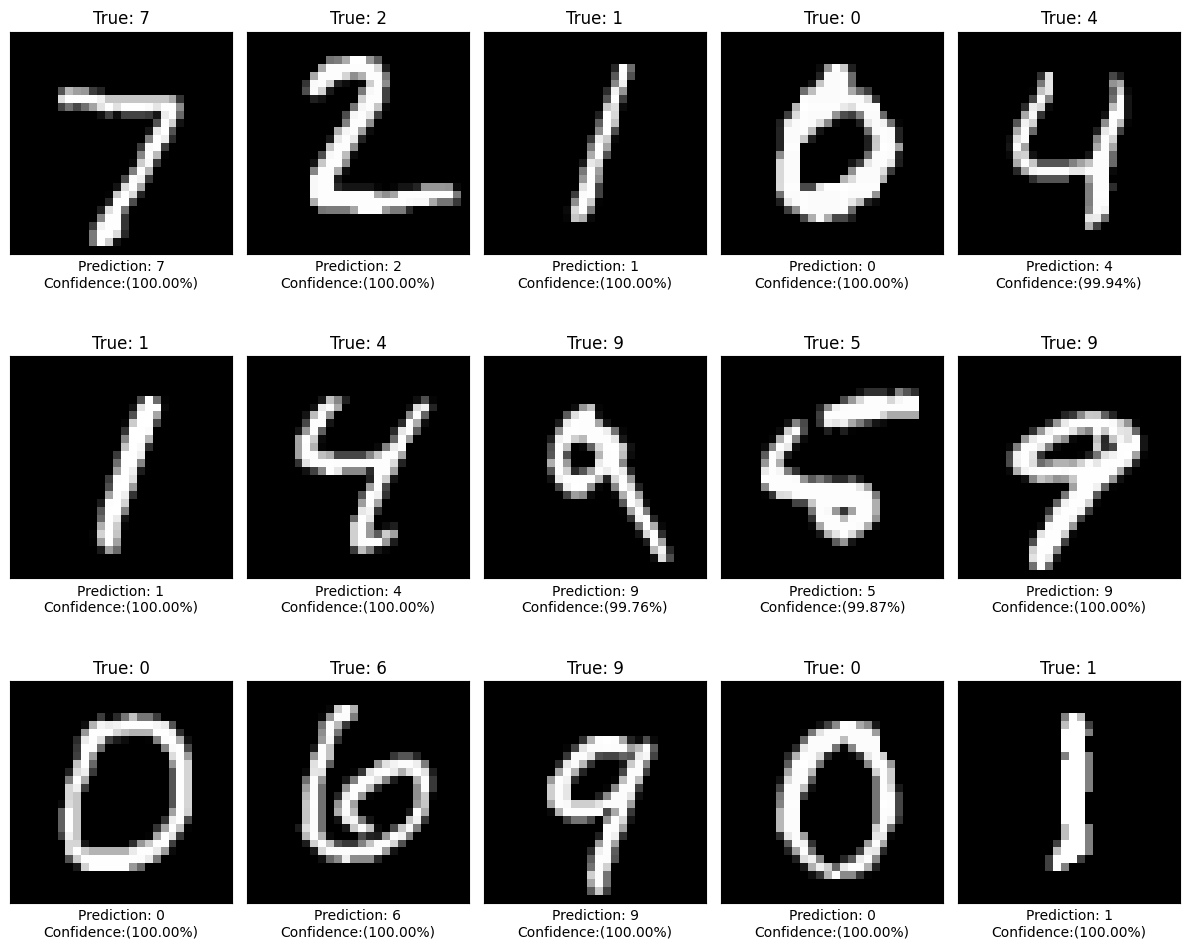

In [24]:
#데이터 시각화
import matplotlib.pyplot as plt
def get_one_result(idx):
  img, y_true, y_pred, confidence = x_test[idx], y_test[idx], np.argmax(predictions[idx]), 100*np.max(predictions[idx])
  return img, y_true, y_pred, confidence

#canvas 생성
fig, axes = plt.subplots(3,5)
fig.set_size_inches(12,10)
for i in range(15):
  ax = axes[i//5, i%5]
  img, y_true, y_pred, confidence = get_one_result(i)
  #imshow로 이미지 시각화
  ax.imshow(img, cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'True: {y_true}')
  ax.set_xlabel(f'Prediction: {y_pred}\nConfidence:({confidence:.2f}%)')
plt.tight_layout()
plt.show()